# Kaggle竞赛: 泰坦尼克号宇宙飞船

## 1. 概述

### 背景

&emsp;&emsp;欢迎来到 2912 年，你需要运用数据科学技能来解开一个宇宙之谜。我们收到了来自四光年外的传输，情况看起来不太妙。
<br/>
&emsp;&emsp;泰坦尼克号宇宙飞船是一个月前发射的星际客轮。这艘船载着近 13,000 名乘客，开始了它的处女航，将来自我们太阳系的移民运送到围绕附近恒星运行的三颗新宜居系外行星。
<br/>
&emsp;&emsp;在绕过半人马座阿尔法星前往其第一个目的地——炎热的巨蟹座 E 星时，粗心的泰坦尼克号宇宙飞船与隐藏在尘埃云中的时空异常相撞。不幸的是，它遭遇了与 1000 年前的同名飞船相似的命运。虽然飞船完好无损，但几乎一半的乘客被送往了另一个维度！
<br/>
&emsp;&emsp;为了帮助救援队找回失踪的乘客，你需要根据从宇宙飞船受损的计算机系统恢复的记录来预测哪些乘客是被异常现象运送的。
<br/>
&emsp;&emsp;帮助拯救他们并改变历史！

### 任务描述

在本次比赛中，您的任务是预测在泰坦尼克号宇宙飞船与时空异常相撞时，乘客是否会被传送到另一个维度。为了帮助您做出这些预测，您将获得一组从飞船受损的计算机系统中恢复的个人记录。

文件和数据字段描述：

- **train.csv**：大约三分之二（~8700）乘客的个人记录，用作训练数据。

  字段说明：
  - `PassengerId`：每位乘客都有一个唯一的 ID，形式为 gggg_pp，gggg 表示乘客与哪个团体一起旅行，pp 是他们在团体中的号码。团体中的人通常是家庭成员，但并非总是如此。
  - `HomePlanet`：乘客出发的星球，通常是其永久居住的星球。
  - `CryoSleep`：表明乘客是否选择在航行期间处于假死状态。处于冷冻睡眠状态的乘客将被限制在船舱内。
  - `Cabin`：乘客所住舱室的舱号，格式为 deck/num/side，其中 side 可以是 P（左舷）或 S（右舷）。
  - `Destination`：乘客将要下船的星球。
  - `Age`：乘客的年龄。
  - `VIP`：乘客是否已支付航行期间的特殊 VIP 服务费用。
  - `RoomService`：乘客在泰坦尼克号宇宙飞船上的众多豪华设施所支付的金额，包括 `FoodCourt`, `ShoppingMall`, `Spa`, `VRDeck`。
  - `Name`：乘客的名字和姓氏。
  - `Transported`：乘客是否被传送至另一个维度（这是目标列，您要预测的内容）。

- **test.csv**：其余三分之一（约 4300 名）乘客的个人记录，用作测试数据。您的任务是预测 `Transported` 列的值。

- **sample_submission.csv**：正确格式的提交文件。

  字段说明：
  - `PassengerId`：测试集中每个乘客的 ID。
  - `Transported`：目标列，您需要预测每位乘客是否被传送至另一个维度，值为 `True` 或 `False`。


## 2. 导入库

In [1]:
import os
import warnings
from typing import Union, Tuple
from pprint import pprint

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.exceptions import FitFailedWarning
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, f1_score, recall_score, precision_score, roc_curve, accuracy_score, auc
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, PredefinedSplit, KFold

warnings.filterwarnings("ignore")
# Suppress warnings
warnings.filterwarnings("ignore", category=UserWarning)  # Suppress UserWarnings
warnings.filterwarnings("ignore", category=FitFailedWarning)  # Suppress FitFailedWarnings


## 3. 读取数据集

In [2]:
if not os.path.exists("./data"):
    !kaggle competitions download -c spaceship-titanic
    !mkdir ./data
    !unzip *.zip -d ./data/
    !rm -rf *.zip
train_df = pd.read_csv('./data/train.csv')  # 训练数据
test_df = pd.read_csv('./data/test.csv')    # 测试数据
print(f"共有{test_df.shape[1]}个特征, {train_df.shape[0]}组训练数据, {test_df.shape[0]}组测试数据")
print(f"{train_df.columns.values}")

共有13个特征, 8693组训练数据, 4277组测试数据
['PassengerId' 'HomePlanet' 'CryoSleep' 'Cabin' 'Destination' 'Age' 'VIP'
 'RoomService' 'FoodCourt' 'ShoppingMall' 'Spa' 'VRDeck' 'Name'
 'Transported']


In [3]:
train_df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [4]:
test_df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
0,0013_01,Earth,True,G/3/S,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning
1,0018_01,Earth,False,F/4/S,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers
2,0019_01,Europa,True,C/0/S,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,Sabih Unhearfus
3,0021_01,Europa,False,C/1/S,TRAPPIST-1e,38.0,False,0.0,6652.0,0.0,181.0,585.0,Meratz Caltilter
4,0023_01,Earth,False,F/5/S,TRAPPIST-1e,20.0,False,10.0,0.0,635.0,0.0,0.0,Brence Harperez


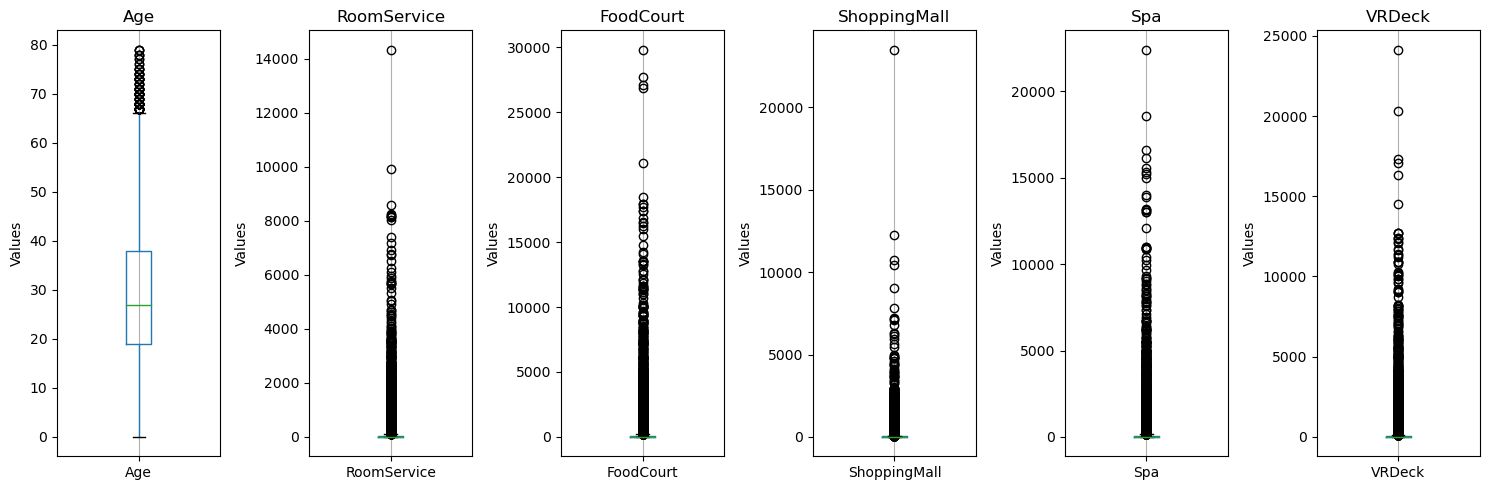

In [5]:
numeric_cols = train_df.select_dtypes(include=['number']).columns

# 创建子图
fig, axs = plt.subplots(nrows=1, ncols=len(numeric_cols), figsize=(15, 5))

# 绘制每个特征的箱线图
for ax, col in zip(axs, numeric_cols):
    train_df.boxplot(column=col, ax=ax)
    ax.set_title(col)
    ax.set_ylabel('Values')
    ax.grid(axis='y')

# 调整布局
plt.tight_layout()
plt.show()

## 4. 数据清洗

In [6]:
train_df.drop(labels='Name', axis=1, inplace=True)

In [7]:
train_df.isnull().sum() / train_df.shape[0]

PassengerId     0.000000
HomePlanet      0.023122
CryoSleep       0.024963
Cabin           0.022892
Destination     0.020936
Age             0.020591
VIP             0.023352
RoomService     0.020821
FoodCourt       0.021051
ShoppingMall    0.023927
Spa             0.021051
VRDeck          0.021627
Transported     0.000000
dtype: float64

In [8]:
train_df.dropna(inplace=True)
train_df.shape

(6764, 13)

## 5. 探索性分析(EDA)

### 不同团体的传送率

In [9]:
train_df['groupID'] = train_df['PassengerId'].str.split('_', expand=True)[0]

In [10]:
grouped_counts = train_df.groupby(by='groupID').size().reset_index(name='group_counts') # type: ignore
grouped_counts['Transported'] = train_df['Transported']
{k: grouped_counts[grouped_counts['group_counts'] == k]['Transported'].mean() for k in grouped_counts['group_counts'].unique()}

{1: 0.4966887417218543,
 2: 0.47305389221556887,
 4: 0.43636363636363634,
 3: 0.5163043478260869,
 6: 0.46153846153846156,
 7: 0.42857142857142855,
 5: 0.3793103448275862,
 8: 1.0}

> 不同团体对传送率没有明显的影响

### 不同星球乘客的传送成功率

#### 数据分布

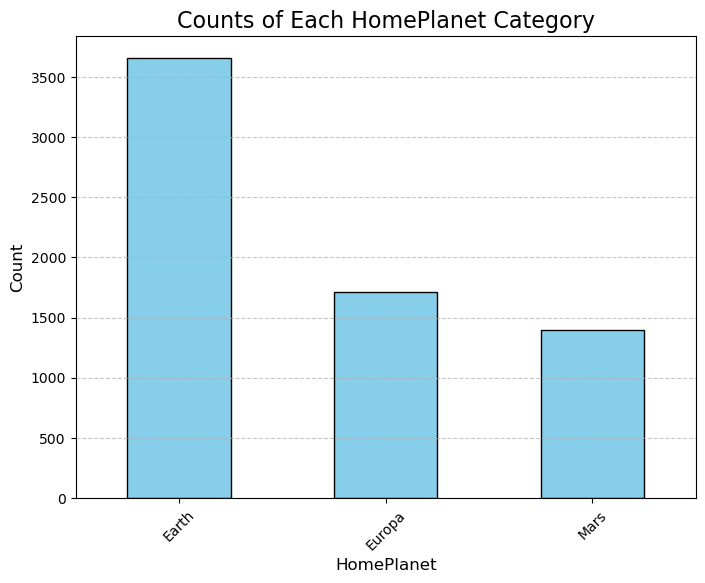

In [11]:
category_counts = train_df['HomePlanet'].value_counts()

# 可视化结果
plt.figure(figsize=(8, 6))
category_counts.plot(kind='bar', color='skyblue', edgecolor='black')

# 添加标题和标签
plt.title('Counts of Each HomePlanet Category', fontsize=16)
plt.xlabel('HomePlanet', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# 显示图表
plt.show()

#### 不同星球的传送率

In [12]:
{k: train_df[train_df['HomePlanet'] == k]['Transported'].mean() for k in train_df['HomePlanet'].unique()}

{'Europa': 0.6580946814728229,
 'Earth': 0.425328227571116,
 'Mars': 0.5153901216893343}

> 这艘宇宙飞船对地球人更友好

### 休眠状态对乘客传送成功率的影响

In [13]:
Transported_rate = [train_df[train_df['CryoSleep'] == status]['Transported'].mean() for status in [True, False]]
Transported_rate

[0.8159663865546218, 0.33280109489051096]

> 结论: 相比之下, 正处于休眠状态的乘客, 更多地被传送到未知维度

### 乘客所住舱室对传送率的影响


In [14]:
train_df['Cabin'].unique()

array(['B/0/P', 'F/0/S', 'A/0/S', ..., 'G/1499/S', 'G/1500/S', 'E/608/S'],
      dtype=object)

In [15]:
def split_cabin(df: pd.DataFrame) -> pd.DataFrame:
    ret_df = df.copy()
    ret_df[['Cabin_deck', 'Cabin_num', 'Cabin_side']] = ret_df['Cabin'].str.split('/', expand=True)
    
    return ret_df

In [16]:
split_df = split_cabin(train_df)
split_df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,groupID,Cabin_deck,Cabin_num,Cabin_side
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,False,0001,B,0,P
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,True,0002,F,0,S
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,False,0003,A,0,S
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,False,0003,A,0,S
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,True,0004,F,1,S


In [17]:
split_df['Cabin_deck'].unique(), split_df['Cabin_num'].unique().shape, split_df['Cabin_side'].unique()

(array(['B', 'F', 'A', 'G', 'E', 'D', 'C', 'T'], dtype=object),
 (1744,),
 array(['P', 'S'], dtype=object))

In [18]:
Transported_rates = {}
for feature_name in ('Cabin_deck', 'Cabin_num', 'Cabin_side'):
    Transported_rates[feature_name] = {k: split_df[split_df[feature_name] == k]['Transported'].mean() for k in split_df[feature_name].unique()}

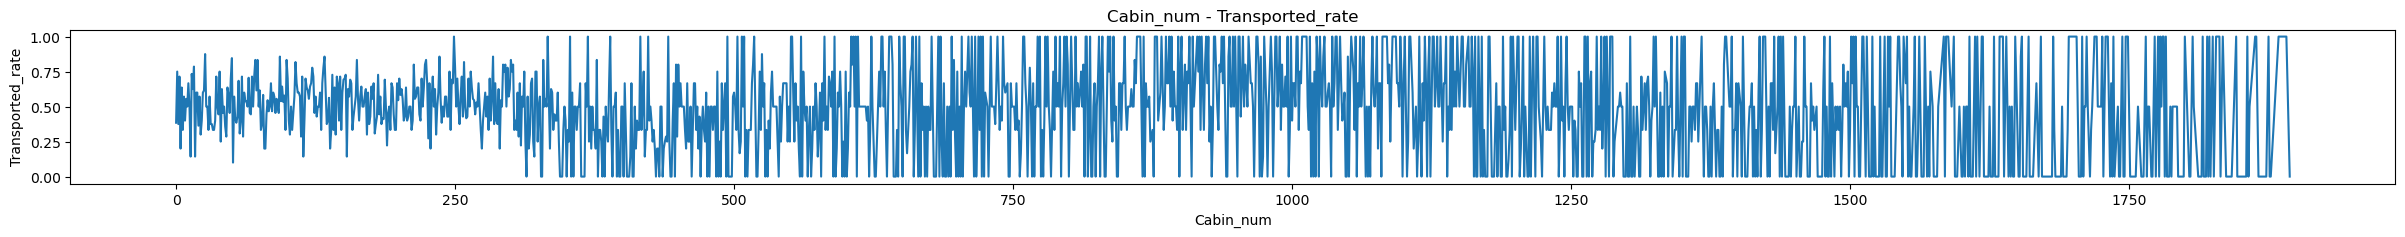

In [19]:
Transported_rates['Cabin_num'] = sorted_dict = {int(k): v for k, v in sorted(Transported_rates['Cabin_num'].items(), key=lambda item: int(item[0]))}
plt.figure(figsize=(30, 2))
plt.plot(Transported_rates['Cabin_num'].keys(), Transported_rates['Cabin_num'].values())
# plt.xlim(0, 100)
plt.title('Cabin_num - Transported_rate')
plt.xlabel('Cabin_num')
plt.ylabel('Transported_rate')
plt.show()

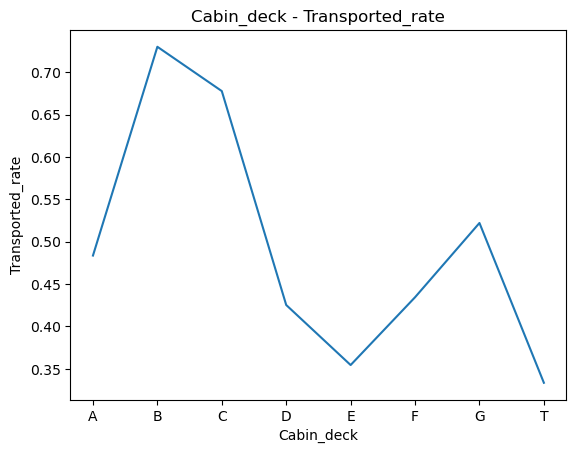

In [20]:
Transported_rates['Cabin_deck'] = sorted_dict = {k: v for k, v in sorted(Transported_rates['Cabin_deck'].items(), key=lambda item: item[0])}
plt.plot(Transported_rates['Cabin_deck'].keys(), Transported_rates['Cabin_deck'].values())
plt.title('Cabin_deck - Transported_rate')
plt.xlabel('Cabin_deck')
plt.ylabel('Transported_rate')
plt.show()

In [21]:
Transported_rates['Cabin_side']

{'P': 0.44893680742737346, 'S': 0.5553284671532847}

> 不同的deck有明显的转移率差异, num未发现明显规律, side 右舷 的 转移率略高于左舷

### 乘客不同下船星球 的传送率

In [22]:
train_df['Destination'].unique()

array(['TRAPPIST-1e', 'PSO J318.5-22', '55 Cancri e'], dtype=object)

In [23]:
{k: train_df[train_df['Destination'] == k]['Transported'].mean() for k in train_df['Destination'].unique()}

{'TRAPPIST-1e': 0.46710807347287486,
 'PSO J318.5-22': 0.5046875,
 '55 Cancri e': 0.6178918169209431}

 > 乘客下船星球的不同, 对于传送率有一些影响

### 不同消费水平的传送率

#### VIP情况

In [24]:
{k: train_df[train_df['VIP'] == k]['Transported'].mean() for k in train_df['VIP'].unique()}

{False: 0.5059090909090909, True: 0.3780487804878049}

> VIP 被传送的比例较非VIP低

#### 消费情况

In [25]:
feature_names = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

##### 特征数据分布

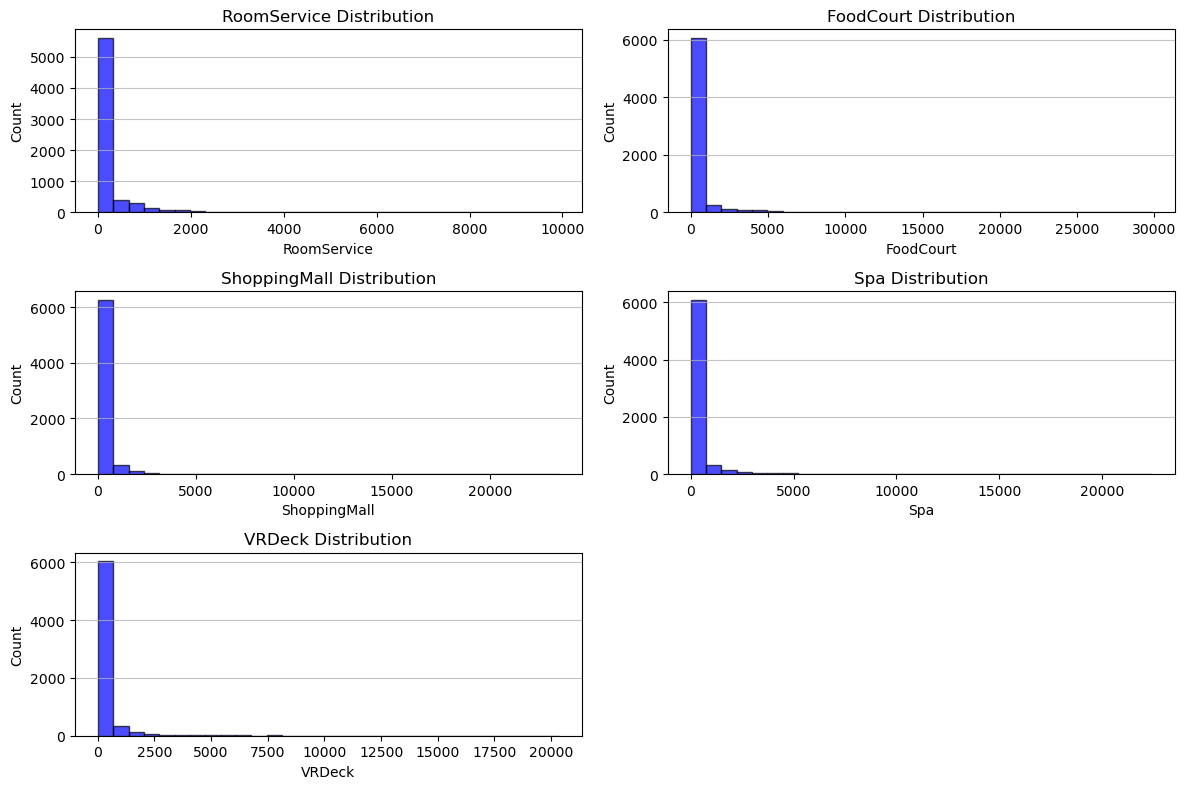

In [26]:
plt.figure(figsize=(12, 8))

# 绘制每个特征的直方图
for i, feature in enumerate(feature_names, 1):
    plt.subplot(3, 2, i)  # 3行2列的子图
    plt.hist(train_df[feature], bins=30, alpha=0.7, color='blue', edgecolor='black')
    plt.title(f'{feature} Distribution')
    plt.xlabel(feature)
    plt.ylabel('Count')  # y轴显示数量
    plt.grid(axis='y', alpha=0.75)

# 调整布局
plt.tight_layout()
plt.show()

##### 对数转换后的分布(不显示0消费)

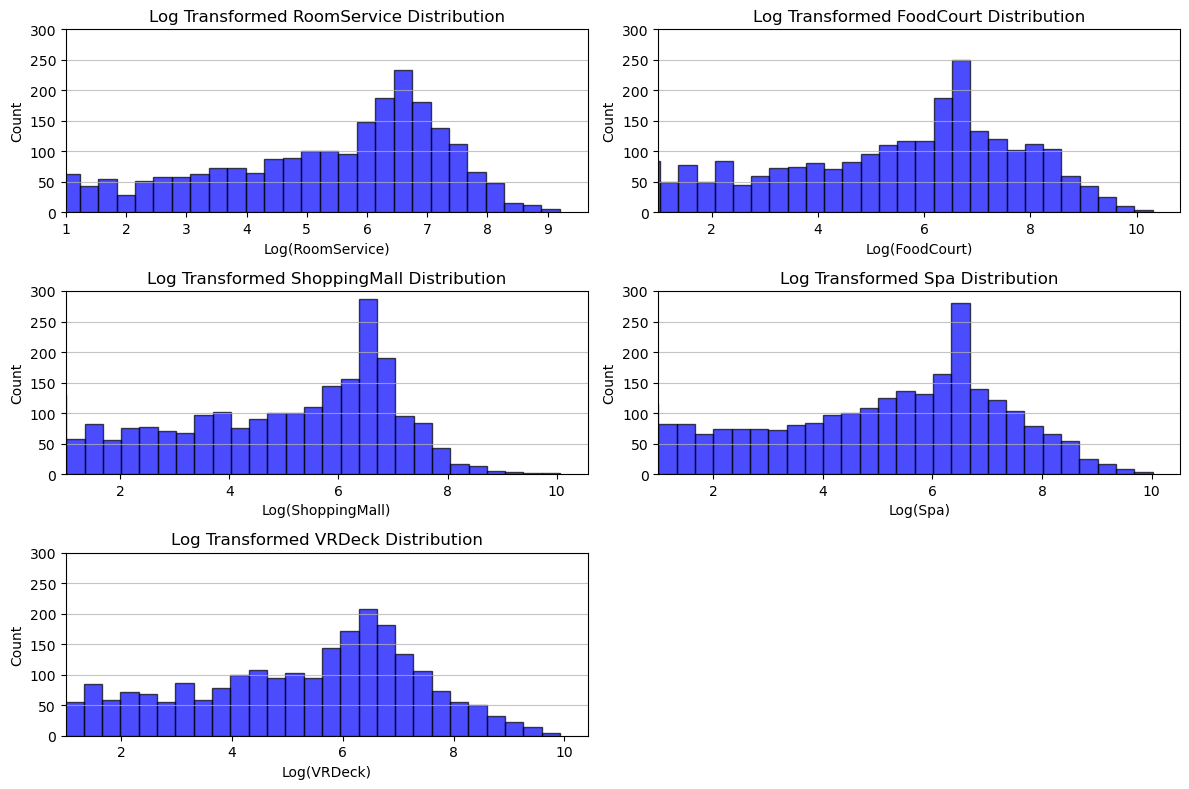

In [27]:
# 对数转换（加1以避免对数零）
log_transformed_df = train_df[feature_names].apply(lambda x: np.log1p(x))

# 设置画布
plt.figure(figsize=(12, 8))

# 绘制每个特征的直方图（对数转换后的）
for i, feature in enumerate(feature_names, 1):
    plt.subplot(3, 2, i)  # 3行2列的子图
    plt.hist(log_transformed_df[feature], bins=30, alpha=0.7, color='blue', edgecolor='black')
    plt.title(f'Log Transformed {feature} Distribution')
    plt.xlabel(f'Log({feature})')
    plt.xlim(1, None)
    plt.ylim(0, 300)
    plt.ylabel('Count')  # y轴显示数量
    plt.grid(axis='y', alpha=0.75)

# 调整布局
plt.tight_layout()
plt.show()

> 接近正态分布

##### 统计是否消费下的传送率

In [28]:
def isService(df:pd.DataFrame, feature_names, inplace=False) -> Tuple[pd.DataFrame]: # type: ignore
    if inplace is None:
        df = df.copy()
    for feature_name in feature_names:
        df[f'is_{feature_name}'] = (df[feature_name] != 0)

    return df # type: ignore

In [29]:
isdf = isService(train_df, feature_names)

In [30]:
for feature_name in feature_names:
    Transported_rates[f"is_{feature_name}"] = {k: isdf[isdf[f"is_{feature_name}"] == k]['Transported'].mean() for k in isdf[f"is_{feature_name}"].unique()} # type: ignore

In [31]:
for feature_name in feature_names:
    feature_name = 'is_' + feature_name
    print(feature_name, Transported_rates[feature_name])

is_RoomService {False: 0.6283646233883736, True: 0.2658984208279983}
is_FoodCourt {False: 0.586906408483172, True: 0.35243198680956306}
is_ShoppingMall {False: 0.5986471251409244, True: 0.3203091455560326}
is_Spa {False: 0.638525564803805, True: 0.27979679562329035}
is_VRDeck {False: 0.6255476135577588, True: 0.2834775442933663}


> 显然, 这艘宇宙飞船同样偏爱有钱人

##### 对数转换后, 不同消费段的传送率

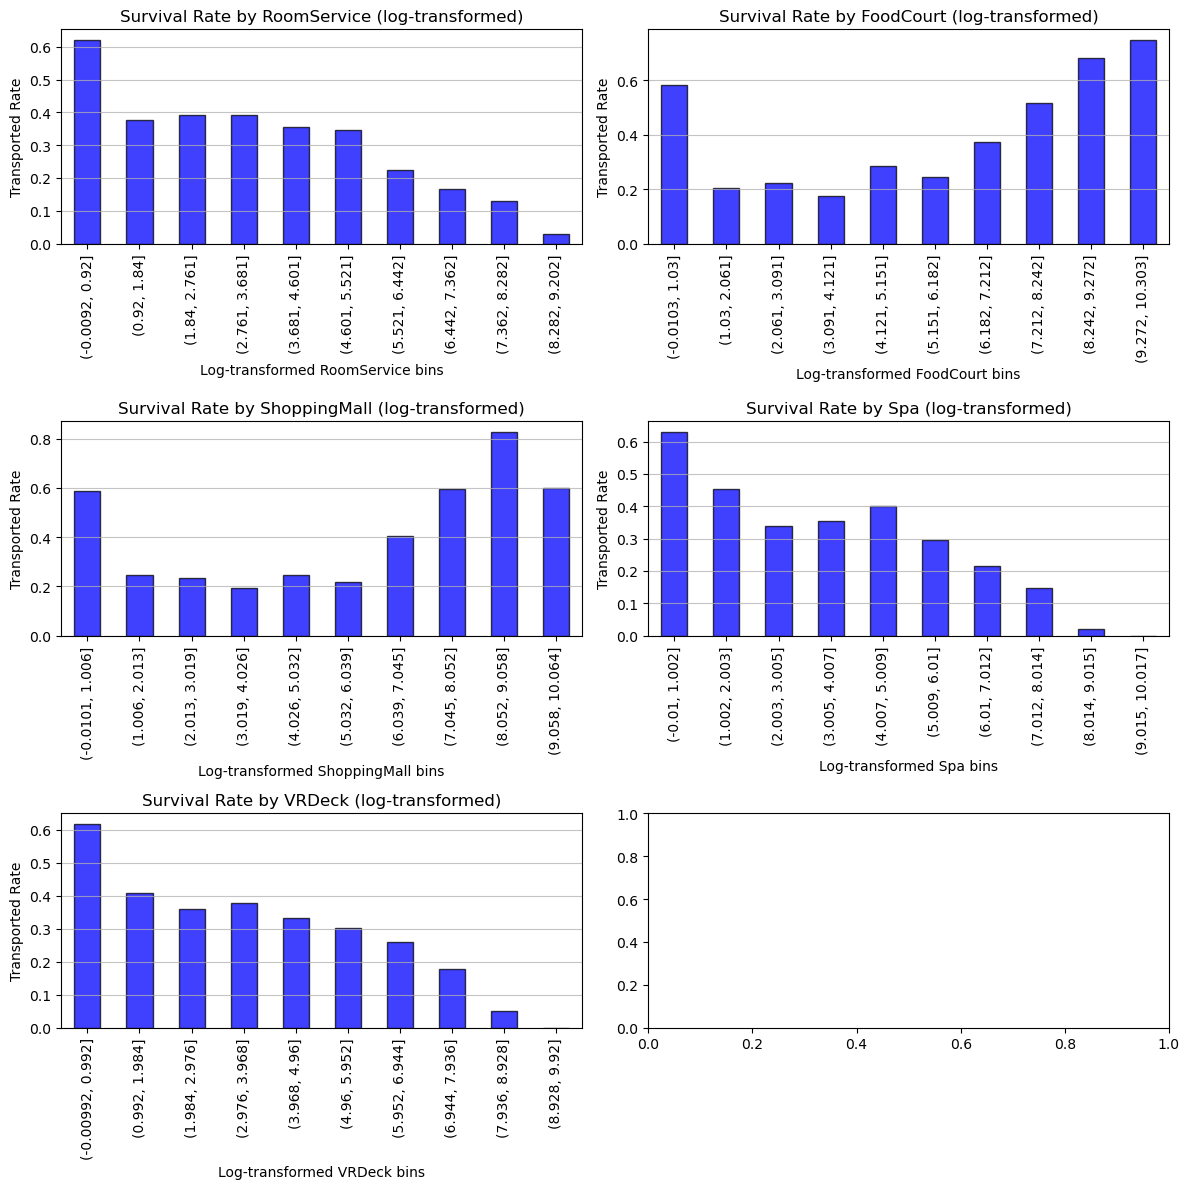

In [32]:
# 设置子图数量，准备在同一个画布上绘制多个图
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(12, 12))
axs = axs.ravel()  # 将子图矩阵展开为一维数组，方便迭代

# 对特征进行区间划分和生存率计算，并绘制到各自的子图
bins = 10  # 划分区间数量

for i, feature in enumerate(feature_names):
    # 划分区间
    train_df[f'{feature}_log_bin'] = pd.cut(log_transformed_df[feature], bins=bins)

    # 计算每个区间的生存率(Transported的均值)
    survival_rate_by_bin = train_df.groupby(f'{feature}_log_bin')['Transported'].mean()

    # 绘制到对应的子图
    survival_rate_by_bin.plot(kind='bar', ax=axs[i], alpha=0.75, color='blue', edgecolor='black')
    axs[i].set_title(f"Survival Rate by {feature} (log-transformed)")
    axs[i].set_xlabel(f"Log-transformed {feature} bins")
    axs[i].set_ylabel("Transported Rate")
    axs[i].grid(axis='y', alpha=0.75)

# 调整布局以避免重叠
plt.tight_layout()
plt.show()

##### 相关性分析

In [33]:
log_transformed_df['Transported'] = train_df['Transported']
corr_materx = log_transformed_df.corr()
corr_materx['Transported']

RoomService    -0.356786
FoodCourt      -0.129238
ShoppingMall   -0.177299
Spa            -0.365176
VRDeck         -0.336211
Transported     1.000000
Name: Transported, dtype: float64

In [34]:
corr_materx = train_df[feature_names + ['Transported']].corr()
corr_materx['Transported']

RoomService    -0.247801
FoodCourt       0.053850
ShoppingMall    0.014998
Spa            -0.220134
VRDeck         -0.207761
Transported     1.000000
Name: Transported, dtype: float64

> 显然, 使用对数转换后的消费变量和传送情况更相关

### 不同年龄的传送率 

In [35]:
train_df['Age'].unique().shape

(80,)

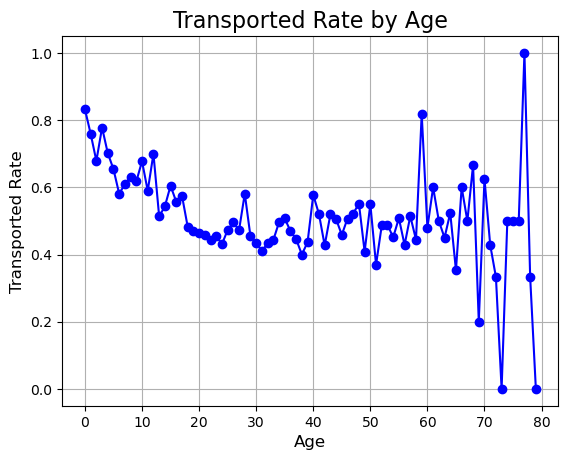

In [36]:
age_transport_rate = train_df.groupby('Age')['Transported'].mean()
plt.plot(age_transport_rate.index, age_transport_rate.values, marker='o', linestyle='-', color='b')
plt.title('Transported Rate by Age', fontsize=16)
plt.xlabel('Age', fontsize=12)
plt.ylabel('Transported Rate', fontsize=12)
plt.grid(True)
plt.show()

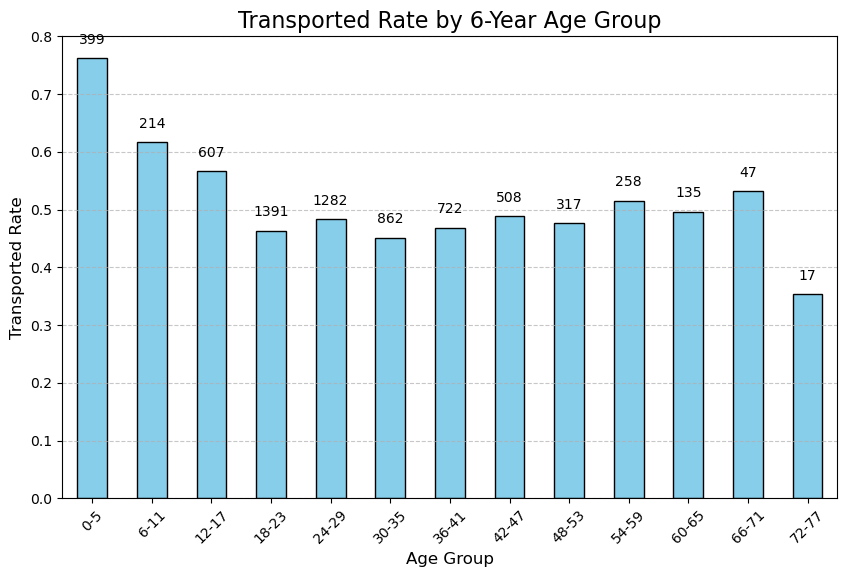

In [37]:
# 设置年龄段，步长为6
bins = np.arange(0, 81, 6)
labels = [f'{i}-{i+5}' for i in range(0, 75, 6)]  # 修改labels的范围，确保比bins少1个

# 对年龄进行分段
train_df['Age_group'] = pd.cut(train_df['Age'], bins=bins, labels=labels, right=False)

# 统计每个年龄段的Transported均值和数量
age_group_transport_rate = train_df.groupby('Age_group')['Transported'].mean()
age_group_counts = train_df.groupby('Age_group').size()  # 统计每个年龄段的数量

# 可视化结果
plt.figure(figsize=(10, 6))
ax = age_group_transport_rate.plot(kind='bar', color='skyblue', edgecolor='black')

# 在每个条形顶部添加统计数量
for i, count in enumerate(age_group_counts):
    ax.text(i, age_group_transport_rate[i] + 0.02, f'{count}', ha='center', va='bottom', fontsize=10)

# 添加标题和标签
plt.title('Transported Rate by 6-Year Age Group', fontsize=16)
plt.xlabel('Age Group', fontsize=12)
plt.ylabel('Transported Rate', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# 显示图表
plt.show()

> 未成年被传送的比例更大

### 小结

1. 对乘客传送率有明显影响的分类指标: CryoSleep、Cabin_deck、VIP 以 是否消费指标
2. 非显著指标: Cabin_deck_num
3. 消费性指标的对数和转移率更相关, 且其中消费人群的分布接近正态

建议作为模型特征的特征量: CryoSleep、是否消费指标、VIP、 消费性指标的对数、年龄

## 特征工程

### 重新读取数据 

In [38]:
train_df = pd.read_csv('./data/train.csv')  # 训练数据
test_df = pd.read_csv('./data/test.csv')    # 测试数据

### 特征拆分

In [39]:
class DataSplitCol(BaseEstimator, TransformerMixin):
    
    def __init__(self): ...

    def fit(self, X, y=None): 
        return self
    
    def transform(self, X: pd.DataFrame):
        df = X.copy()
        df[['Cabin_deck', 'Cabin_num', 'Cabin_side']] = df['Cabin'].str.split('/', expand=True)
        return df        

### 删除指定列

In [40]:
class DataDropCol(BaseEstimator, TransformerMixin):

    def __init__(self, drop_lst = []):
        self.drop_lst = drop_lst

    def fit(self, X, y=None): 
        return self
    
    def transform(self, X: pd.DataFrame):
        return X.drop(labels=self.drop_lst, axis=1)

### one-hot 

In [41]:
class DataOneHot(BaseEstimator, TransformerMixin):
    
    def __init__(self, cols = []):
        self.cols = cols

    def fit(self, X, y=None): 
        return self
    
    def transform(self, X: pd.DataFrame):
        df = X.copy()
        for col in self.cols:
            df = pd.get_dummies(df, columns=[col], prefix=col)
        return df

### 数据清洗 Class

In [42]:
class DataCleaner(BaseEstimator, TransformerMixin):

    def __init__(self, ignore_columns=None):
        # ignore_columns 参数允许指定不清洗的列
        self.ignore_columns = ignore_columns if ignore_columns else []

    def fit(self, X, y=None):
        return self

    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        X_cleaned = X.copy()
        # X_cleaned.dropna(inplace=True)
        for name in X_cleaned.columns:
            X_cleaned[name].fillna(X_cleaned[name].median(), inplace=True)

        return X_cleaned

### 特征值转换

In [43]:
class DataLog1p(BaseEstimator, TransformerMixin):

    def __init__(self): ...

    def fit(self, X, y=None):
        return self
    
    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        feature_names =  ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
        df = X.copy()
        for name in feature_names:
            df[name] = np.log1p(df[name])
        return df

### bool -> int

In [44]:
class BooleanToIntTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        # 复制数据以避免修改原始 DataFrame
        X_transformed = X.copy()
        
        # 查找布尔类型的列，并将它们转换为 int 类型
        bool_columns = X_transformed.select_dtypes(include='bool').columns
        X_transformed[bool_columns] = X_transformed[bool_columns].astype(int)
        
        
        bool_columns = X_transformed.select_dtypes(include='object').columns
        X_transformed[bool_columns] = X_transformed[bool_columns].astype(int)

        return X_transformed

### 组装流水线

In [45]:
EF_PipeLine = Pipeline(steps=[
    ('Split', DataSplitCol()),
    ('dropName', DataDropCol(['PassengerId', 'Name', 'Cabin', 'Cabin_num', 'HomePlanet', 'Destination'])),
    ('oneHot', DataOneHot(['Cabin_deck', 'Cabin_side'])),
    ('cleaner', DataCleaner()), 
    ('bool_to_int', BooleanToIntTransformer()),
    ('log1p', DataLog1p()),
    # ('scaler', StandardScaler())
])

## 建模

#### 数据划分

In [104]:
train_Xy = EF_PipeLine.fit_transform(train_df)

In [105]:
X_train, y_train = train_Xy.drop(labels='Transported', axis=1).values, train_Xy['Transported'].values   # type: ignore

### 归一化

In [106]:
scaler = StandardScaler()
X_train_scaler = scaler.fit_transform(X_train)

### 模型验证

In [107]:
models = dict(
    rf=RandomForestClassifier(oob_score=True),
    xgb=XGBClassifier(),
    lr=LogisticRegression()
)

In [108]:
param_grid = {
    'rf': {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 5, 10, 20],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'bootstrap': [True, False]
    },
    'xgb': {
        'learning_rate': [0.01, 0.1, 0.3],
        'max_depth': [3, 6, 10],
        'n_estimators': [50, 100, 200],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
    },
    'lr': {
        'C': [0.01, 0.1, 1, 10, 100],
        'penalty': ['l1', 'l2'],
        'solver': ['liblinear', 'saga']
    }
}

In [109]:
# KFold 用于交叉验证
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# 存储各模型的评估结果
results = {name: [] for name in models.keys()}

# 对每个模型进行交叉验证
for name, model in models.items():
    print(f"Training {name}...")
    
    # 创建 GridSearchCV 对象，使用 K 折交叉验证
    search = GridSearchCV(estimator=model, param_grid=param_grid[name], cv=kf, scoring='accuracy', verbose=0, n_jobs=-1)
    
    # 进行网格搜索训练
    search.fit(X_train_scaler, y_train)
    
    # 获取最佳模型
    best_model = search.best_estimator_
    print(f'Best parameters for {name}: {search.best_params_}')
    
    # 预测和计算各折的性能指标
    for train_index, test_index in kf.split(X_train_scaler):
        X_train_cv, X_test_cv = X_train_scaler[train_index], X_train_scaler[test_index]
        y_train_cv, y_test_cv = y_train[train_index], y_train[test_index]
        
        best_model.fit(X_train_cv, y_train_cv)
        y_pred = best_model.predict(X_test_cv)
        y_proba = best_model.predict_proba(X_test_cv)[:, 1]
        
        # 计算各项指标
        acc_score = accuracy_score(y_test_cv, y_pred)
        f1 = f1_score(y_test_cv, y_pred)
        recall = recall_score(y_test_cv, y_pred)
        precision = precision_score(y_test_cv, y_pred)
        auc = roc_auc_score(y_test_cv, y_proba)
        
        # 存储结果
        results[name].append({
            'Accuracy': acc_score,
            'F1': f1,
            'Recall': recall,
            'Precision': precision,
            'AUC': auc,
            "proba": y_proba,  # Store predicted probabilities
            'best_params': search.best_params_
        })

Training rf...


/root/miniconda3/envs/d2l/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/root/miniconda3/envs/d2l/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/root/miniconda3/envs/d2l/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 352, in fit
    raise ValueError("Out of bag estimation only available"
ValueError: Out of bag estimation only available if bootstrap=True

  warnings.warn("Estimator fit failed. The score on this train-test"
/root/miniconda3/envs/d2l/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent

Best parameters for rf: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
Training xgb...
Best parameters for xgb: {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 10, 'n_estimators': 200, 'subsample': 0.6}
Training lr...


/root/miniconda3/envs/d2l/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/root/miniconda3/envs/d2l/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/root/miniconda3/envs/d2l/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/root/miniconda3/envs/d2l/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/root/miniconda3/envs/d2l/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: 

Best parameters for lr: {'C': 0.1, 'penalty': 'l1', 'solver': 'saga'}


## 提交

In [50]:
train_Xy = EF_PipeLine.fit_transform(train_df)
X_test = EF_PipeLine.fit_transform(test_df)
X_train, y_train = train_Xy.drop(labels='Transported', axis=1).values, train_Xy['Transported'].values   # type: ignore
feature_names =  train_Xy.drop(labels='Transported', axis=1).columns # type: ignore
scaler = StandardScaler()
X_train_scaler = scaler.fit_transform(X_train)
X_test_scaler = scaler.transform(X_test)

### XGBoost

In [47]:
model = XGBClassifier(**{'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 10, 'n_estimators': 200, 'subsample': 0.6})
model.fit(X_train_scaler, y_train)
y_pred = model.predict(X_test_scaler)
y_pred

array([1, 0, 1, ..., 1, 1, 1])

In [54]:
from xgboost import plot_importance

# 获取不同类型的特征重要度
weight = model.get_booster().get_score(importance_type='weight')  # 分裂次数
gain = model.get_booster().get_score(importance_type='gain')      # 信息增益
cover = model.get_booster().get_score(importance_type='cover')    # 覆盖样本

weight = {feature_names[int(k[1:])]: v for k, v in weight.items()}
gain = {feature_names[int(k[1:])]: v for k, v in gain.items()}
cover = {feature_names[int(k[1:])]: v for k, v in cover.items()}

# 创建 DataFrame 便于比较
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Weight': [weight.get(f, 0) for f in feature_names],
    'Gain': [gain.get(f, 0) for f in feature_names],
    'Cover': [cover.get(f, 0) for f in feature_names]
}).sort_values(by='Gain', ascending=False)

# 打印结果
print(importance_df)



         Feature  Weight        Gain        Cover
0      CryoSleep   149.0  317.874939  1109.204834
14  Cabin_deck_G   466.0   21.846025   161.645523
3    RoomService  2467.0    7.404932    76.070480
9   Cabin_deck_B   288.0    7.328761   168.549744
6            Spa  3211.0    7.278824    70.777725
7         VRDeck  2837.0    7.260301    62.535336
12  Cabin_deck_E   477.0    6.912451    87.498848
10  Cabin_deck_C   509.0    5.884257   110.322006
4      FoodCourt  3422.0    5.302145    60.736233
5   ShoppingMall  2986.0    4.142781    57.426826
13  Cabin_deck_F   504.0    4.104175    66.730530
17  Cabin_side_S   649.0    2.890507    67.505005
11  Cabin_deck_D   237.0    2.700300    76.280647
16  Cabin_side_P  1135.0    2.641682    43.762054
8   Cabin_deck_A   206.0    2.151868    62.769272
1            Age  8554.0    1.863828    34.192661
2            VIP    66.0    1.530647    37.914879
15  Cabin_deck_T     0.0    0.000000     0.000000


### Random Forset

In [54]:
model = RandomForestClassifier(bootstrap=True, min_samples_leaf=1, min_samples_split=2, n_estimators=100)
model.fit(X_train_scaler, y_train)
y_pred = model.predict(X_test_scaler)
y_pred

array([1, 0, 1, ..., 1, 1, 0])

### 生成提交

In [113]:
output = pd.DataFrame({'PassengerId': test_df.PassengerId, 'Transported': y_pred == 1})
output.to_csv('./data/submission.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!


In [114]:
!kaggle competitions submit -c spaceship-titanic -f ./data/submission.csv -m "XGB, 经过超参数网格调优后2"

100%|██████████████████████████████████████| 56.3k/56.3k [00:01<00:00, 55.6kB/s]
Successfully submitted to Spaceship Titanic